In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 데이터셋 구축

In [2]:
import glob
import torch
import numpy as np
import os
import tqdm

import matplotlib.pyplot as plt
from PIL import Image

path_to_annotation = '/content/drive/MyDrive/2023_딥러닝/ch07/CH07_data/annotations/trimaps/'
path_to_image = '/content/drive/MyDrive/2023_딥러닝/ch07/CH07_data/images/'

In [3]:
images = sorted(glob.glob(path_to_image+"/*.jpg"))

for i in images:
    img = Image.open(i)
    img = np.array(img)
    if img.shape[-1] != 3:
        filename = i.split("/")[-1].split(".")[0]
        gt_filename = filename+".png"

        os.remove(os.path.join(path_to_annotation, gt_filename))
        os.remove(i)

이미지 불러오기

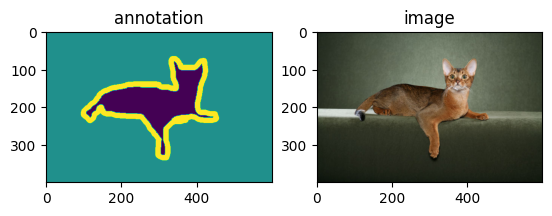

In [4]:
annotation = Image.open(path_to_annotation + 'Abyssinian_1.png')

plt.subplot(1, 2, 1)
plt.title('annotation')
plt.imshow(annotation)

image = Image.open(path_to_image + 'Abyssinian_1.jpg')
plt.subplot(1, 2, 2)
plt.title('image')
plt.imshow(image)

plt.show()

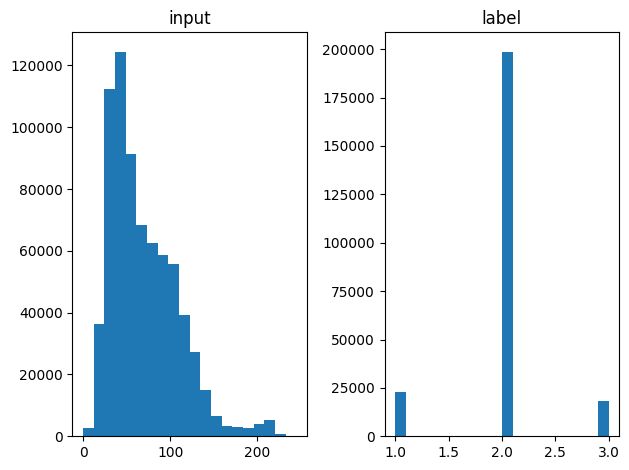

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

annotation = Image.open(path_to_annotation + 'Abyssinian_1.png')
image = Image.open(path_to_image + 'Abyssinian_1.jpg')

annotation_array = np.array(annotation)
image_array = np.array(image)

plt.subplot(122)
plt.hist(annotation_array.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(image_array.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()


In [7]:
path_to_image

'/content/drive/MyDrive/2023_딥러닝/ch07/CH07_data/images/'

In [8]:
images = sorted(glob.glob(path_to_image+"/*.jpg"))
annotations = sorted(glob.glob(path_to_annotation+"/*.png"))

In [9]:
len(images), len(annotations)

(7378, 7378)

In [10]:
import pandas as pd

df_images = pd.DataFrame({'images':images, 'anno':annotations})

df_images['images'] = df_images['images'].apply(lambda x : x.split('/')[-1])
df_images['anno'] = df_images['anno'].apply(lambda x : x.split('/')[-1])

df_images['images'] = df_images['images'].apply(lambda x : x.split('.')[0])
df_images['anno'] = df_images['anno'].apply(lambda x : x.split('.')[0])

df_images

,images,anno
0,Abyssinian_1,Abyssinian_1
1,Abyssinian_10,Abyssinian_10
2,Abyssinian_100,Abyssinian_100
3,Abyssinian_101,Abyssinian_101
4,Abyssinian_102,Abyssinian_102
...,...,...
7373,yorkshire_terrier_95,yorkshire_terrier_95
7374,yorkshire_terrier_96,yorkshire_terrier_96
7375,yorkshire_terrier_97,yorkshire_terrier_97
7376,yorkshire_terrier_98,yorkshire_terrier_98


In [11]:
(df_images['images'] != df_images['anno']).sum()

0

# 2. DataLoader 정의하기

In [12]:
from torch.utils.data.dataset import Dataset
from PIL import Image

class Pets(Dataset):
    def __init__(self, path_to_img,
                path_to_anno, train=True,
                transforms=None, input_size=(128, 128)):
        self.images = sorted(glob.glob(path_to_img+"/*.jpg"))
        self.annotations = sorted(glob.glob(path_to_anno+"/*.png"))



        self.X_train = self.images[:int(0.8*len(self.images))]
        self.X_test = self.images[int(0.8*len(self.images)):]
        self.y_train = self.annotations[:int(0.8*len(self.annotations))]
        self.y_test = self.annotations[int(0.8*len(self.annotations)):]

        self.train = train
        self.transforms = transforms
        self.input_size = input_size

    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)

    def preprocess_mask(self, mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask[mask != 2.0] = 1.0
        mask[mask == 2.0] = 0.0
        mask = torch.tensor(mask)
        return mask

    def __getitem__(self, i):
        if self.train:
            X_train = Image.open(self.X_train[i])
            X_train = self.transforms(X_train)
            y_train = Image.open(self.y_train[i])
            y_train = self.preprocess_mask(y_train)

            return X_train, y_train
        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            y_test = Image.open(self.y_test[i])
            y_test = self.preprocess_mask(y_test)

            return X_test, y_test

# 3. U-Net 모델 정의하기

In [13]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
        #     layers = []
        #     layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
        #                          kernel_size=kernel_size, stride=stride, padding=padding,
        #                          bias=bias)]
        #     layers += [nn.BatchNorm2d(num_features=out_channels)]
        #     layers += [nn.ReLU()]

        #     cbr = nn.Sequential(*layers)

        #     return cbr


        # 인코더에서 사용되는 은닉층
        # 수축 1단계
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 수축 2단계
        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 수축 3단계
        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 수축 4단계
        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        # 확장 경로(Expansive path)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)

        self.upsample4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec4_1 = nn.Conv2d(2*512, 512, kernel_size=3, padding=1) # 수축경로 특성맵 합해서 채널이 2배가 됨
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)

        self.upsample3 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.dec3_1 = nn.Conv2d(2*256, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)

        self.upsample2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.dec2_1 = nn.Conv2d(2*128, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)

        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.dec1_1 = nn.Conv2d(2*64, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=3, padding=1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)

        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)

        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)

        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)

        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)

        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)

        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)

        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)

        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)

        x = torch.squeeze(x) # 흑백이미지로 처리하기 위해서 채널을 1개로 만들어

        return x

# 4. 모델 학습하기

In [14]:
import tqdm

from torchvision.transforms import Compose, ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# 5. 데이터 불러오기

In [14]:
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

train_set = Pets(path_to_img = path_to_image,
                path_to_anno = path_to_annotation,
                transforms = transform)

test_set = Pets(path_to_img = path_to_image,
                path_to_anno = path_to_annotation,
                transforms = transform,
               train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

In [18]:
from torchvision.transforms import Compose, Resize, ToTensor, RandomHorizontalFlip, Normalize

transform = Compose([
    Resize((128, 128)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Use appropriate mean and std values
])

train_set = Pets(path_to_img=path_to_image, path_to_anno=path_to_annotation, transforms=transform)
test_set = Pets(path_to_img=path_to_image, path_to_anno=path_to_annotation, transforms=transform, train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


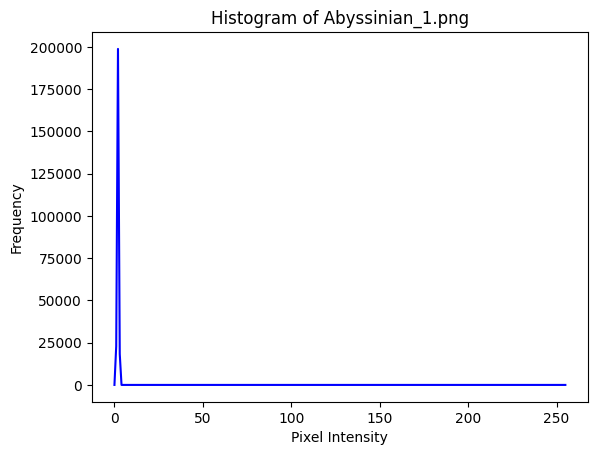

In [23]:
import cv2
import matplotlib.pyplot as plt

# Load the image using OpenCV
image_path = path_to_annotation + 'Abyssinian_1.png'
image = cv2.imread(image_path)

# Convert the image from BGR to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Calculate the histogram
histogram = cv2.calcHist([image_rgb], [0], None, [256], [0, 256])

# Plot the histogram
plt.plot(histogram, color='b')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Abyssinian_1.png')
plt.show()


# 6. 모델, 학습률, 최적화 정의

In [15]:
model = UNet().to(device)

learning_rate = 0.0001
optim = Adam(params=model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss()

# 7. 학습

In [ ]:
best_loss = float('inf')

for epoch in range(100):
    iterator = tqdm.tqdm(train_loader)
    avg_loss = 0
    for data, label in iterator:
        data, label = data.to(device), label.type(torch.FloatTensor).to(device)

        optim.zero_grad()
        preds = model(data.to(device))
        loss = loss_fn(preds, label)
        loss.backward()
        optim.step()

        iterator.set_description(f'epoch : {epoch+1}, loss :{loss.item()}')

        # 현재 loss 값과 최소 loss 값을 비교하여 모델 저장
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), './UNet.pth')

epoch : 57, loss :0.07064726948738098:  52%|█████▏    | 96/185 [01:05<00:58,  1.51it/s]

# 8. 모델 성능 평가

In [1]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet.pth', map_location="cpu"))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0)) > 0.5

with torch.no_grad():
    plt.subplot(1, 2, 1)
    plt.title('Predicted')
    plt.imshow(pred.to('cpu'))
    plt.subplot(1, 2, 2)
    plt.title('Real')
    plt.imshow(label)
    plt.show()

NameError: ignored